# Prototype Training Script to Fine-Tune EfficientNet for Palm Oil Fruit Classificaton

In [22]:
from autogluon.multimodal import MultiModalPredictor
from autogluon.multimodal.presets import get_automm_presets
from IPython.display import Image, display
from ray import tune
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json
import yaml
import uuid
import zipfile
import os
import datetime
import torch
import onnx
import onnxruntime

In [2]:
torch.set_float32_matmul_precision("high")

In [3]:
def unzip(filepath, extract_to):
    if not zipfile.is_zipfile(filepath):
        print("filepath error")
        return
    with zipfile.ZipFile(filepath, 'r') as zipped:
        zipped.extractall(extract_to)

In [4]:
filepath="data/raw/ImageClassificationReducedClass.v1i.folder.zip"
extract_to="data/intermediate"

unzip(filepath, extract_to)

In [5]:
def convert_folder_to_autogluon_format(path):
    columns = ["image", "label_text"]
    df = pd.DataFrame(columns=columns)
    for root, dirs, files in os.walk(path):
        for file in files:
            file_paths = os.path.abspath(os.path.join(root, file))
            label_text = os.path.basename(os.path.dirname(file_paths))
            new_row = {"image": file_paths, "label_text": label_text}
            df.loc[len(df)] = new_row
    return df

In [6]:
train_filepath = "data/intermediate/train"
train_df = convert_folder_to_autogluon_format(train_filepath)
train_df

,image,label_text
0,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
1,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
2,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
3,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
4,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
...,...,...
2644,e:\Current_Workdir\palm-fruit-classification\d...,unripe
2645,e:\Current_Workdir\palm-fruit-classification\d...,unripe
2646,e:\Current_Workdir\palm-fruit-classification\d...,unripe
2647,e:\Current_Workdir\palm-fruit-classification\d...,unripe


In [7]:
test_filepath = "data/intermediate/valid"
test_df = convert_folder_to_autogluon_format(test_filepath)
test_df

,image,label_text
0,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
1,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
2,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
3,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
4,e:\Current_Workdir\palm-fruit-classification\d...,empty_bunch
...,...,...
374,e:\Current_Workdir\palm-fruit-classification\d...,unripe
375,e:\Current_Workdir\palm-fruit-classification\d...,unripe
376,e:\Current_Workdir\palm-fruit-classification\d...,unripe
377,e:\Current_Workdir\palm-fruit-classification\d...,unripe


In [8]:
train_df.to_csv("data/clean/train_df.csv", index=False)
test_df.to_csv("data/clean/test_df.csv", index=False)

In [ ]:
now = datetime.datetime.now()
timestamp_str = now.strftime("%Y-%m-%d_%H-%M-%S")
model_path = "model/" + f"train_{timestamp_str}"

In [ ]:
predictor = MultiModalPredictor(label="label_text", path=model_path, problem_type='multiclass', eval_metric="f1_macro")

In [ ]:
np.unique(train_df["label_text"])

In [ ]:
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(train_df["label_text"]), y=train_df["label_text"])
class_weights

In [ ]:
class_weights_list = class_weights.tolist()
class_weights_list

In [ ]:
hyperparameters = {
    "optimization.learning_rate": tune.loguniform(0.00005, 0.001),
    "optimization.max_epochs":tune.randint(5,20),
    "env.batch_size": tune.qlograndint(8,128,2),
    "optimization.loss_function": "focal_loss",
    "optimization.focal_loss.alpha": class_weights_list,
    "optimization.focal_loss.gamma": tune.uniform(0, 1),
    "optimization.focal_loss.reduction": "sum",
    "model.timm_image.checkpoint_name": tune.choice(["efficientnet_b0.ra_in1k"]),
    "optimization.optim_type": "adamw"
}

In [ ]:
hyperparameter_tune_kwargs = {
    "searcher": "bayes",
    "scheduler": "ASHA",
    # "num_trials": 2
}

In [ ]:
predictor.fit(
        train_data=train_df,
        hyperparameters=hyperparameters,
        hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
        time_limit = 3600
    )

In [13]:
predictor = MultiModalPredictor.load("e:/Current_Workdir/palm-fruit-classification/model/train_2024-10-08_18-03-14")

Load pretrained checkpoint: e:\Current_Workdir\palm-fruit-classification\model\train_2024-10-08_18-03-14\model.ckpt


In [ ]:
predictor.fit_summary()

In [ ]:
scores = predictor.evaluate(test_df, metrics=["f1_macro", "f1_micro", "accuracy", "recall_macro", "precision_macro"])
scores

In [ ]:
preds = predictor.predict(test_df)

In [ ]:
true_labels = test_df['label_text']

In [ ]:
cm = confusion_matrix(true_labels, preds)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predictor.class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

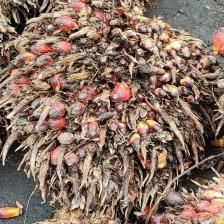

In [10]:
image_path = test_df.iloc[0]['image']
pil_img = Image(filename=image_path)
display(pil_img)

In [11]:
image_path

'e:\\Current_Workdir\\palm-fruit-classification\\data\\intermediate\\valid\\empty_bunch\\IMG_20220803_112710_crop_0_jpg.rf.bfef2ca25d24fefe9a8c64c68c5bb66f.jpg'

In [14]:
predictions = predictor.predict({'image': [image_path]})
predictions

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  3.29it/s]


array(['overripe'], dtype=object)

In [15]:
proba = predictor.predict_proba({'image': [image_path]})
print(proba)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 41.38it/s]
[[1.7925164e-04 9.9974495e-01 1.2928008e-05 1.6278818e-05 4.6521458e-05
  1.4056458e-07]]


In [16]:
feature = predictor.extract_embedding({'image': [image_path]})
print(feature[0].shape)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 38.22it/s]
(1280,)


In [17]:
predictor.dump_model("./timm")

Model timm_image weights saved to ./timm\timm_image/pytorch_model.bin.
Timm config saved to ./timm\timm_image/config.json.


'./timm'

In [24]:
predictor.optimize_for_inference()

NotImplementedError: export_onnx doesn't support model type <class 'autogluon.multimodal.utils.onnx.OnnxModule'>

In [28]:
predictor.save("/onnx", standalone=True)

AttributeError: 'OnnxModule' object has no attribute 'state_dict'

In [29]:
predictions_onnx = predictor.predict({'image': [image_path]})
predictions_onnx

Predicting DataLoader 0: 100%|██████████| 1/1 [00:06<00:00,  0.16it/s]


array(['overripe'], dtype=object)

## Trying out TIMM Inference

In [ ]:
import torch
import timm
from torchvision import transforms
from PIL import Image

# Load a pretrained EfficientNet model from TIMM
model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=False)
model.load_state_dict(torch.load('E:/Current_Workdir/palm-fruit-classification/model/train_2024-10-08_18-03-14/deployment/timm_image/pytorch_model.bin'))
model.eval()

# Load and preprocess an image
img = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization
])
img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

# Inference
with torch.no_grad():
    output = model(img_tensor)

# Post-process the output (e.g., for classification tasks)
# Here we're assuming a classification task and output contains logits
_, predicted_class = output.max(1)
print(f"Predicted class: {predicted_class.item()}")

In [ ]:
import torch
import timm

# Paths to your config.json and pytorch_model.bin
config_path = 'E:/Current_Workdir/palm-fruit-classification/model/train_2024-10-08_18-03-14/deployment/timm_image/config.json'  # This typically contains model-specific hyperparameters
model_path = 'E:/Current_Workdir/palm-fruit-classification/model/train_2024-10-08_18-03-14/deployment/timm_image/pytorch_model.bin'

# Load the model configuration (optional, for advanced customization)
# 'config.json' may not be directly required unless you need to load specific settings
# You can manually specify the model architecture type from the config
# For example, if your model is a ResNet, you'd specify that.

# Load the model architecture (change 'resnet50' to the appropriate model name)
model = timm.create_model('efficientnet_b0.ra_in1k', pretrained=False)  # Change to the correct model type

# Load the model weights
model.load_state_dict(torch.load(model_path))

# Ensure the model is in evaluation mode
model.eval()

# Example of using the model for inference (adjust input as needed)
dummy_input = torch.randn(1, 3, 224, 224)  # Example input for an image model like ResNet
output = model(dummy_input)

print(output)

In [ ]:
import timm
model = timm.create_model('efficientnet_b0.ra_in1k', checkpoint_path='E:/Current_Workdir/palm-fruit-classification/timm/timm_image/pytorch_model.bin')

In [21]:
import timm
import torch

# Define the model architecture that matches AutoGluon’s model
model = timm.create_model('efficientnet_b0', pretrained=False)  # Replace with appropriate model name

# Load the weights from the AutoGluon model
model_weights = torch.load("timm/timm_image/pytorch_model.bin")

# Load the weights into the TIMM model
model.load_state_dict(model_weights)

RuntimeError: Error(s) in loading state_dict for EfficientNet:
	Missing key(s) in state_dict: "classifier.weight", "classifier.bias". 